In [1]:
# Credit Risk Modelling — LendingClub Dataset

#Objective: Predict loan default probability using borrower attributes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
df = pd.read_csv('../data/lending.csv')
df.head()
#we load in the dataset


/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/111071305.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lending.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['loan_status'].value_counts()
#all the values for the loans

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [5]:
def map_to_default(status):
    if status in ['Charged Off', 'Default','Late (31-120 days)']:
        return 1
    else:
        return 0
df['default_flag'] = df['loan_status'].apply(map_to_default)
#creation of new variable that gives us binary classification for default and non-default.

In [6]:
df['default_flag'].value_counts()
#the values for default and non-default.

default_flag
0    1970635
1     290066
Name: count, dtype: int64

In [7]:
df['default_flag'] = df['loan_status'].apply(map_to_default)
df['default_flag'].value_counts()

default_flag
0    1970635
1     290066
Name: count, dtype: int64

In [8]:
df.columns
#will list all the columns for the data.

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_last_payment_amount', 'disbursement_method',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term', 'default_flag'],
      dtype='object', length=152)

In [9]:
drop_cols = [
    'id', 'member_id', 'url', 'zip_code', 'addr_state', 'emp_title', 'title',
    'issue_d', 'last_pymnt_d', 'last_pymnt_amnt', 'recoveries',
    'collection_recovery_fee', 'last_credit_pull_d', 'application_type',
    'policy_code', 'hardship_flag', 'hardship_type', 'hardship_reason',
    'hardship_status', 'hardship_amount', 'payment_plan_start_date',
    'hardship_end_date', 'hardship_last_payment_amount',
    'debt_settlement_flag', 'settlement_status', 'settlement_amount',
    'settlement_percentage', 'settlement_term'
]

df = df.drop(columns=drop_cols, errors='ignore')
#clean the dataset by removing leakage and irrelevant variables.

In [10]:
selected_features = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'tot_cur_bal', 'total_rev_hi_lim'
]

df_model = df[selected_features + ['default_flag']]
df_model.head()
#extract the modelling dataset to make it clean and easier to work with and display the head.

,loan_amnt,term,int_rate,installment,grade,sub_grade,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,delinq_2yrs,inq_last_6mths,tot_cur_bal,total_rev_hi_lim,default_flag
0,3600.0,36 months,13.99,123.03,C,C4,55000.0,5.91,7.0,0.0,2765.0,29.7,13.0,0.0,1.0,144904.0,9300.0,0
1,24700.0,36 months,11.99,820.28,C,C1,65000.0,16.06,22.0,0.0,21470.0,19.2,38.0,1.0,4.0,204396.0,111800.0,0
2,20000.0,60 months,10.78,432.66,B,B4,63000.0,10.78,6.0,0.0,7869.0,56.2,18.0,0.0,0.0,189699.0,14000.0,0
3,35000.0,60 months,14.85,829.90,C,C5,110000.0,17.06,13.0,0.0,7802.0,11.6,17.0,0.0,0.0,301500.0,67300.0,0
4,10400.0,60 months,22.45,289.91,F,F1,104433.0,25.37,12.0,0.0,21929.0,64.5,35.0,1.0,3.0,331730.0,34000.0,0


In [11]:
df_model.isnull().mean().sort_values(ascending=False).head(20)
#check for missing values.

total_rev_hi_lim    0.031101
tot_cur_bal         0.031101
revol_util          0.000812
dti                 0.000771
inq_last_6mths      0.000028
pub_rec             0.000027
delinq_2yrs         0.000027
open_acc            0.000027
total_acc           0.000027
annual_inc          0.000016
loan_amnt           0.000015
revol_bal           0.000015
term                0.000015
sub_grade           0.000015
grade               0.000015
installment         0.000015
int_rate            0.000015
default_flag        0.000000
dtype: float64

In [12]:
for col in selected_features:
    if df_model[col].dtype != 'object':
        df_model[col].fillna(df_model[col].median(), inplace=True)
#handle missing values by using median filling as it is robust against skew.

/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/1175217737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(df_model[col].median(), inplace=True)
/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/1175217737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col].fillna(df_model[

In [13]:
df_model['term'] = df_model['term'].str.extract(r'(\d+)').astype(float)
df_model['term'] = df_model['term'].fillna(df_model['term'].median())
df_model['term'] = df_model['term'].astype(int)
#convert terms into numeric values (e.g. "20 months" --> "20".

/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/2351041219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['term'] = df_model['term'].str.extract(r'(\d+)').astype(float)
/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/2351041219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['term'] = df_model['term'].fillna(df_model['term'].median())
/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/2351041219.py:3: SettingWithCopyWarning: 
A value

In [14]:
df_model['term'].value_counts()

term
36    1609787
60     650914
Name: count, dtype: int64

In [15]:
df_model = df_model.copy()
#create into a copy.

In [16]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_model.loc[:, 'grade'] = df_model['grade'].map(grade_mapping)
#encode grade.

In [17]:
subgrade_order = ['A1','A2','A3','A4','A5',
                  'B1','B2','B3','B4','B5',
                  'C1','C2','C3','C4','C5',
                  'D1','D2','D3','D4','D5',
                  'E1','E2','E3','E4','E5',
                  'F1','F2','F3','F4','F5',
                  'G1','G2','G3','G4','G5']

subgrade_mapping = {sg: idx for idx, sg in enumerate(subgrade_order)}
df_model.loc[:, 'sub_grade'] = df_model['sub_grade'].map(subgrade_mapping)
#encode subgrade.

df_model['sub_grade'] = df_model['sub_grade'].fillna(-1).astype(int)
#to handle NaN or missing values.

/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/543402440.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['sub_grade'] = df_model['sub_grade'].fillna(-1).astype(int)


In [18]:
df_model[['grade', 'sub_grade']].head()
df_model.dtypes
df_model.isnull().sum()
#check

loan_amnt            0
term                 0
int_rate             0
installment          0
grade               33
sub_grade            0
annual_inc           0
dti                  0
open_acc             0
pub_rec              0
revol_bal            0
revol_util           0
total_acc            0
delinq_2yrs          0
inq_last_6mths       0
tot_cur_bal          0
total_rev_hi_lim     0
default_flag         0
dtype: int64

In [19]:
df_model['grade'] = df_model['grade'].fillna(df_model['grade'].median())

/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/2785093634.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['grade'] = df_model['grade'].fillna(df_model['grade'].median())


In [20]:
df_model.isnull().sum()

loan_amnt           0
term                0
int_rate            0
installment         0
grade               0
sub_grade           0
annual_inc          0
dti                 0
open_acc            0
pub_rec             0
revol_bal           0
revol_util          0
total_acc           0
delinq_2yrs         0
inq_last_6mths      0
tot_cur_bal         0
total_rev_hi_lim    0
default_flag        0
dtype: int64

In [21]:
#all 0 so now we start on logitistic regression.

In [22]:
import sklearn
from sklearn.model_selection import train_test_split
#import all the modules needed for regression

In [23]:
X = df_model.drop('default_flag', axis=1)
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train.shape, X_test.shape

((1808560, 17), (452141, 17))

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))
print()
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.7274374716884405

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.65      0.77    394128
           1       0.22      0.68      0.34     58013

    accuracy                           0.66    452141
   macro avg       0.58      0.66      0.55    452141
weighted avg       0.84      0.66      0.71    452141


Confusion matrix:
[[257902 136226]
 [ 18824  39189]]


In [26]:
import pandas as pd

fi = pd.Series(model.feature_importances_, index=X.columns)
fi.sort_values(ascending=False)

sub_grade           0.254952
int_rate            0.240702
grade               0.213131
tot_cur_bal         0.033562
dti                 0.028608
total_rev_hi_lim    0.027779
inq_last_6mths      0.027492
installment         0.026607
annual_inc          0.026497
term                0.023057
revol_util          0.021996
loan_amnt           0.020806
revol_bal           0.018096
total_acc           0.016101
open_acc            0.013352
delinq_2yrs         0.003780
pub_rec             0.003483
dtype: float64

In [27]:
from sklearn.metrics import precision_score, recall_score

for t in [0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1]:
    pred = (y_proba > t).astype(int)
    recall1 = recall_score(y_test, pred, pos_label=1)
    precision1 = precision_score(y_test, pred, pos_label=1)
    print(f"Threshold {t}: precision={precision1:.3f}, recall={recall1:.3f}")
#we use this and with the ouput we see that we catch more defaulters with recall increasing, however our precision
# decreases and we accuse many good borrowers of being risky.
    

Threshold 0.5: precision=0.223, recall=0.676
Threshold 0.4: precision=0.184, recall=0.845
Threshold 0.3: precision=0.159, recall=0.941
Threshold 0.25: precision=0.150, recall=0.964
Threshold 0.2: precision=0.143, recall=0.981
Threshold 0.15: precision=0.137, recall=0.993
Threshold 0.1: precision=0.131, recall=0.999


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

t = 0.3
y_thresh = (y_proba > t).astype(int)

print("Threshold:", t)
print("\nClassification report:\n", classification_report(y_test, y_thresh))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_thresh))
#at t=0.3 threshold the model identified 94% of future defaulters, at the cost of a higher false positive, which is an
# acceptable trade-off in credit risk management.

Threshold: 0.3

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.26      0.42    394128
           1       0.16      0.94      0.27     58013

    accuracy                           0.35    452141
   macro avg       0.56      0.60      0.34    452141
weighted avg       0.86      0.35      0.40    452141


Confusion matrix:
 [[104428 289700]
 [  3431  54582]]


In [29]:
import matplotlib.pyplot as plt
import numpy as np

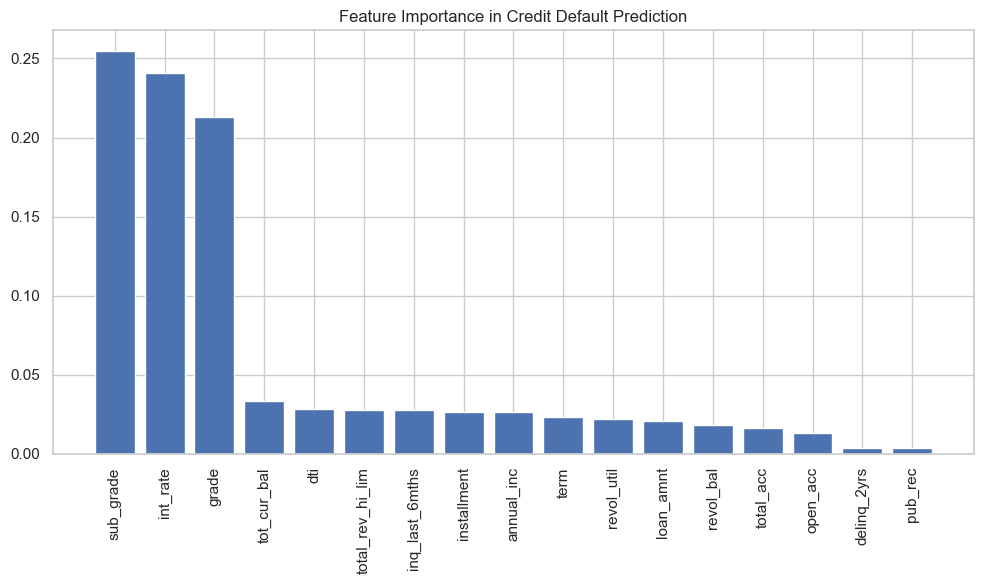

In [30]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importance in Credit Default Prediction")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

#visual represntation of how credit grade, subgrade, interest rate, income etc affect the likelyhood of default from borrowers.

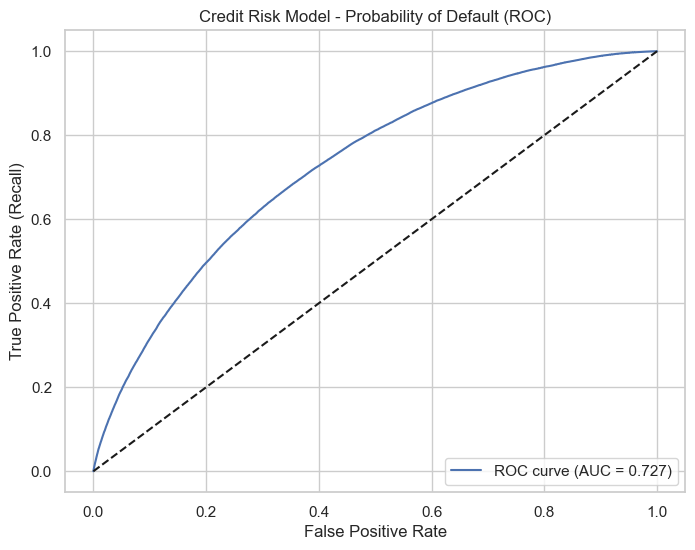

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Credit Risk Model - Probability of Default (ROC)")
plt.legend(loc="lower right")
plt.show()

#plot a graph to visualize the model's ability to distinguish between default and non-default loans, with the auc measuring
#the overall classification performance.

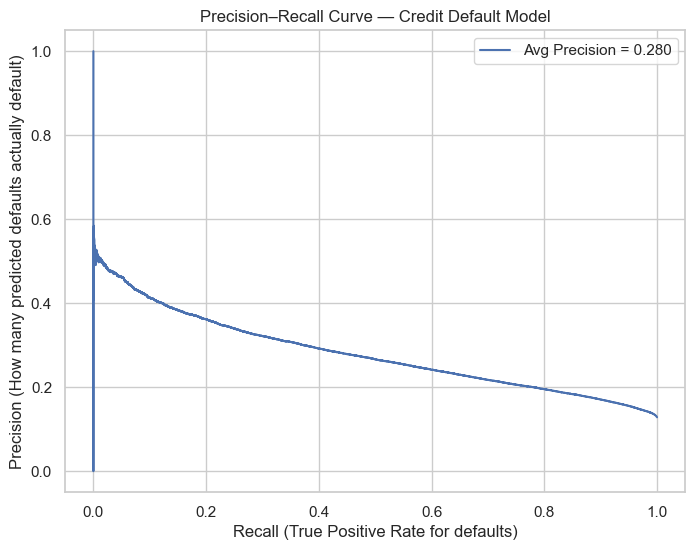

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Avg Precision = {avg_prec:.3f}")
plt.xlabel("Recall (True Positive Rate for defaults)")
plt.ylabel("Precision (How many predicted defaults actually default)")
plt.title("Precision–Recall Curve — Credit Default Model")
plt.legend(loc="upper right")
plt.show()

#the Avg Precision shows what percentage of the predicted defaults actually default.

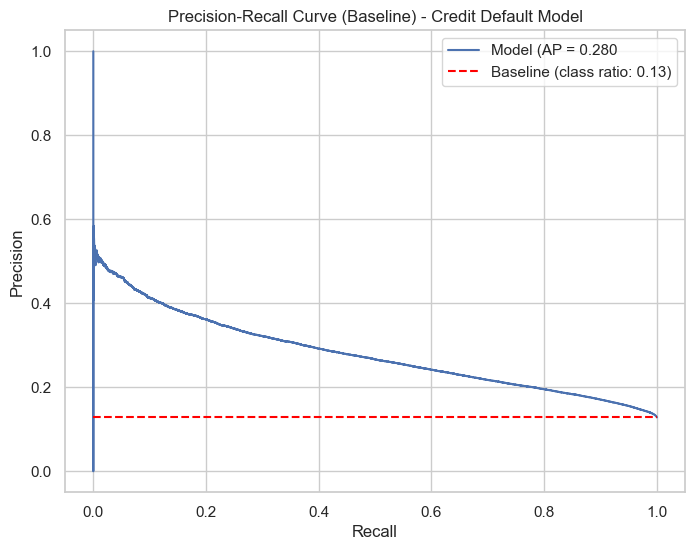

In [33]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"Model (AP = {avg_prec:.3f}")
plt.hlines(y=0.13, xmin=0, xmax=1, colors='red', linestyles='--', label='Baseline (class ratio: 0.13)')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Baseline) - Credit Default Model")
plt.legend()
plt.show()

In [34]:
from sklearn.model_selection import train_test_split

X_full = df_model.drop('default_flag', axis=1)
y_full = df_model['default_flag']

X_small, _, y_small, _ = train_test_split(
    X_full, y_full,
    train_size=200_000,
    stratify=y_full,
    random_state=42
)

print("Sample size:", X_small.shape)

#now we create a smaller dataset with 200,000 samples for faster gradient boosting.

Sample size: (200000, 17)


In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

print("Training Gradient Boosting...")
gb = GradientBoostingClassifier()
gb.fit(X_small, y_small)
print("GB training finished.")

# Evaluate using the test set from original split:
y_proba_gb = gb.predict_proba(X_test)[:, 1]
print("ROC-AUC (Gradient Boosting, 200k training):", roc_auc_score(y_test, y_proba_gb))

Training Gradient Boosting...
GB training finished.
ROC-AUC (Gradient Boosting, 200k training): 0.7159189967826516


In [36]:
import xgboost as xgb
print("XGBoost OK")

XGBoost OK


In [37]:
print("Sample size for XGBoost:", X_small.shape)

# Define and train XGBoost model on the 200k sample
model_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='auc',
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)

print("Training XGBoost...")
model_xgb.fit(X_small, y_small)
print("XGBoost training finished.")

y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
print("ROC-AUC (XGBoost, 200k training):", roc_auc_score(y_test, y_proba_xgb))

#We define and train XGBoost on the 200k sample then evaluate on the same test we did with RandomForest.

Sample size for XGBoost: (200000, 17)
Training XGBoost...
XGBoost training finished.
ROC-AUC (XGBoost, 200k training): 0.7330762933215926


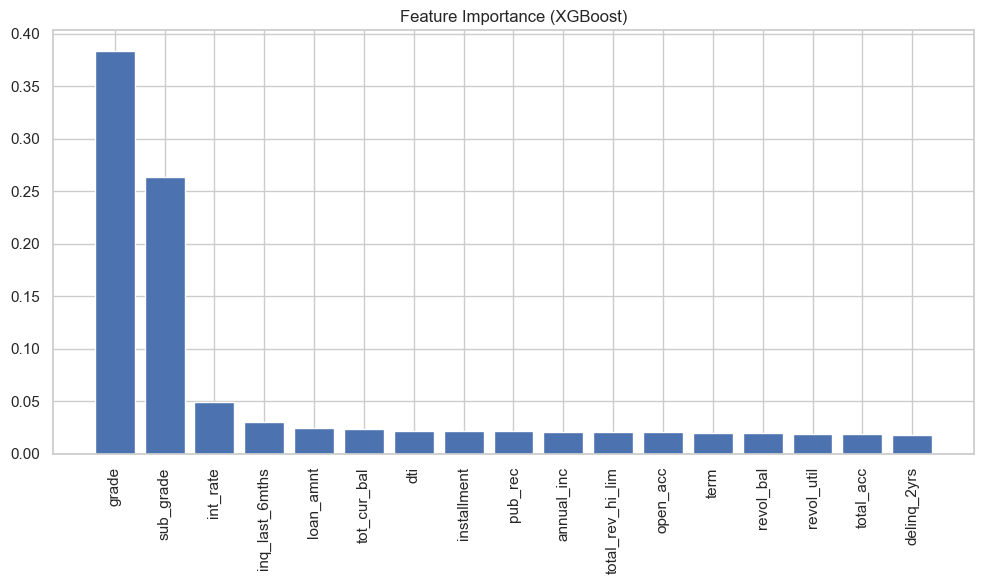

In [38]:
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importance (XGBoost)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [39]:
best_model = model_xgb
#set the xgboost model as the best model.

In [40]:
import pandas as pd

importance_xgb = pd.Series(model_xgb.feature_importances_, index=X.columns)
importance_xgb.sort_values(ascending=False).head(20)

#We extract the feature importance values learned by the XGBoost model and then we map them to the corresponding feature names.
#Then it sorts them by importance and provides the top contributors to loan default prediction.

grade               0.383766
sub_grade           0.263704
int_rate            0.049576
inq_last_6mths      0.030790
loan_amnt           0.024482
tot_cur_bal         0.023827
dti                 0.022121
installment         0.021972
pub_rec             0.021868
annual_inc          0.021323
total_rev_hi_lim    0.020958
open_acc            0.020579
term                0.020029
revol_bal           0.019672
revol_util          0.018889
total_acc           0.018508
delinq_2yrs         0.017934
dtype: float32

In [41]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_proba[:10]
#get predicted probabilities for all the test samples.

array([0.04925925, 0.05735167, 0.09798914, 0.24745347, 0.14496133,
       0.22120605, 0.06195477, 0.14640845, 0.06574752, 0.1299951 ],
      dtype=float32)

In [42]:
risk_bins = pd.qcut(y_pred_proba, 5, labels=[
    "Very Low Risk",
    "Low Risk",
    "Medium Risk",
    "High Risk",
    "Very High Risk"
])
risk_bins[:20]
#create 5 risk buckets to sort loans into.

['Low Risk', 'Low Risk', 'Medium Risk', 'Very High Risk', 'High Risk', ..., 'High Risk', 'Very Low Risk', 'Very Low Risk', 'High Risk', 'Very Low Risk']
Length: 20
Categories (5, object): ['Very Low Risk' < 'Low Risk' < 'Medium Risk' < 'High Risk' < 'Very High Risk']

In [43]:
bucket_analysis = pd.DataFrame({
    "predicted_PD": y_pred_proba,
    "actual_default": y_test.values,
    "risk_bucket": risk_bins
})

bucket_analysis.head()
#we combine predictions, actual defaults and risk buckets.

,predicted_PD,actual_default,risk_bucket
0,0.049259,0,Low Risk
1,0.057352,0,Low Risk
2,0.097989,0,Medium Risk
3,0.247453,1,Very High Risk
4,0.144961,0,High Risk


In [44]:
bucket_summary = bucket_analysis.groupby("risk_bucket").agg(
    avg_predicted_PD = ("predicted_PD", "mean"),
    actual_default_rate = ("actual_default", "mean"),
    count = ("actual_default", "count")
)

bucket_summary
#the stability of buckets (actual vs predicted).

/var/folders/5j/w_2sgj8s5gx6k6d04z4rkbqr0000gn/T/ipykernel_49396/861841747.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = bucket_analysis.groupby("risk_bucket").agg(


,avg_predicted_PD,actual_default_rate,count
risk_bucket,,,
Very Low Risk,0.027988,0.025611,90429
Low Risk,0.064623,0.062271,90428
Medium Risk,0.103476,0.106947,90428
High Risk,0.158235,0.162837,90428
Very High Risk,0.284643,0.283872,90428


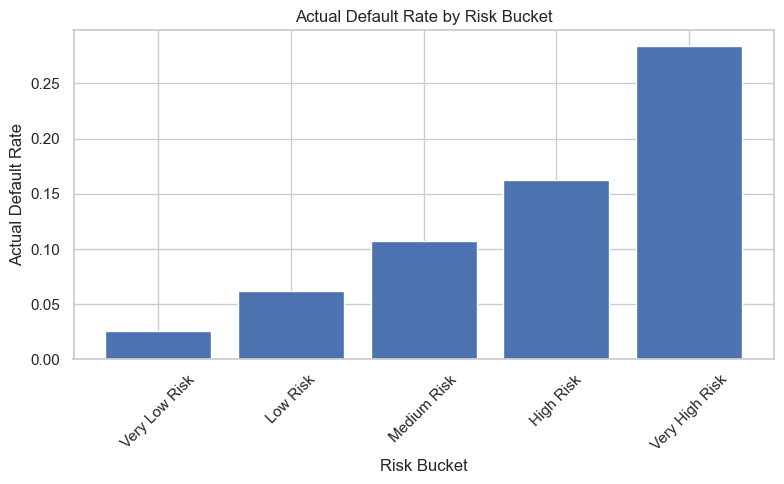

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.bar(
    bucket_summary.index.astype(str),
    bucket_summary["actual_default_rate"]
)

plt.title("Actual Default Rate by Risk Bucket")
plt.xlabel("Risk Bucket")
plt.ylabel("Actual Default Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#we plot the bar chart of the buckets vs their actual default rate.           

Kolmogorov-Smirnov Statistic: 0.3405727329677559
Kolmogorov-Smirnov Threshold: 0.12248529


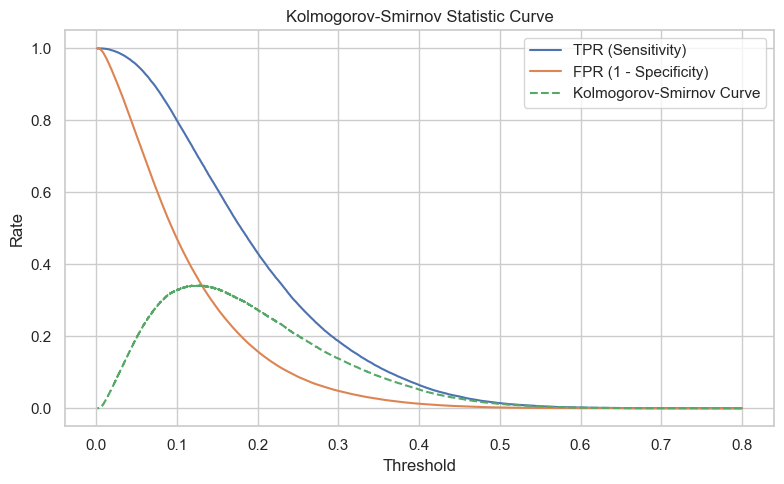

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

ks_statistic = max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]

print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("Kolmogorov-Smirnov Threshold:", ks_threshold)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, tpr, label="TPR (Sensitivity)")
plt.plot(thresholds, fpr, label="FPR (1 - Specificity)")
plt.plot(thresholds, tpr - fpr, label="Kolmogorov-Smirnov Curve", linestyle='--')

plt.title("Kolmogorov-Smirnov Statistic Curve")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plot the Kolmogorov-Smirnov Statistic curve to show how well our model seperates defaulters and non-defaulters.